In [1]:
!unzip /content/PINN-CGM-masterr.zip

Archive:  /content/PINN-CGM-masterr.zip
   creating: PINN-CGM-master/
  inflating: PINN-CGM-master/dataviz.ipynb  
  inflating: PINN-CGM-master/model1.ipynb  
  inflating: PINN-CGM-master/MonitorCGM.txt  
  inflating: __MACOSX/PINN-CGM-master/._MonitorCGM.txt  
  inflating: PINN-CGM-master/MonitorTotalBolus.txt  
  inflating: __MACOSX/PINN-CGM-master/._MonitorTotalBolus.txt  
  inflating: PINN-CGM-master/.gitignore  
  inflating: PINN-CGM-master/preprocess.ipynb  
  inflating: PINN-CGM-master/utils.py  
  inflating: PINN-CGM-master/Evonorm.ipynb  
  inflating: PINN-CGM-master/notes.md  
  inflating: PINN-CGM-master/data.py  
  inflating: PINN-CGM-master/MonitorMeal.txt  
  inflating: __MACOSX/PINN-CGM-master/._MonitorMeal.txt  


In [2]:
%cd PINN-CGM-master 

/content/PINN-CGM-master


In [3]:
!ls

data.py        model1.ipynb	MonitorTotalBolus.txt  utils.py
dataviz.ipynb  MonitorCGM.txt	notes.md
Evonorm.ipynb  MonitorMeal.txt	preprocess.ipynb


In [4]:
!python data.py
!python utils.py


In [ ]:
%run "preprocess.ipynb"


In [ ]:
%run "model1.ipynb"


In [8]:
def glucose_insulin_model(t, u, p_est, p_fix, t_range, D_t, U_t):

    G_p, G_t, I_l, I_p, I_1, I_d, Q_sto1, Q_sto2, Q_gut, X, I_sc1, I_sc2 = u

    # parameters
    k_p2, k_1, k_2, k_p1, k_i, k_e1, k_max, k_min, k_abs, k_p3, k_gri = p_est
    F_cns, k_e2, f, BW, V_m0, V_mx, K_m0, K_mx, m_2, m_1, m_6, k_a1, m_4, k_a2, V_I, a, b, c, d, p_2U, I_b, k_d = p_fix

    # noise
    δ = np.random.normal(0, 1)

    # meal intake
    D = D_t[np.abs(t_range - t).argmin()]

    # insulin infusion rate
    U = U_t[np.abs(t_range - t).argmin()]

    dG_p = k_p1 - F_cns - (k_1 * G_p) + (k_2 * G_t) - (k_p2 * G_p) - (k_p3 * I_d) + (k_e1 * (k_e2 - G_p)) + ((f * k_abs * Q_gut)/BW)
    dG_t = (k_1 * G_p) - (k_2 * G_t) - ((G_t * (V_m0 + (V_mx * X))) / (K_m0 + G_t + (K_mx * X)))
    dI_l = (m_2 * I_p) - I_l * (m_1 - ((m_1 * m_6) / (m_6 - 1)))
    dI_p = (k_a1 * I_sc1) - (I_p * (m_2 + m_4)) + (k_a2 * I_sc2) + (m_1 * I_l)
    dI_1 = -k_i * (I_1 - (I_p / V_I))
    dI_d = k_i * (I_1 - I_d)
    dQ_sto1 = (-k_gri * Q_sto1) + D * δ
    dQ_sto2 = (k_gri * Q_sto1) - Q_sto2 * (k_min + ((k_max / 2) - (k_min / 2)) * (np.tanh(a * (Q_sto1 + Q_sto2 - (b * D))) - np.tanh(c * (Q_sto1 + Q_sto2 - (d * D))) + 2))
    dQ_gut = Q_sto2 * (k_min + ((k_max / 2) - (k_min / 2)) * (np.tanh(a * (Q_sto1 + Q_sto2 - (b * D))) - np.tanh(c * (Q_sto1 + Q_sto2 - (d * D))) + 2)) - (k_abs * Q_gut)
    dX = -p_2U * (I_b - (I_p / V_I)) - (p_2U * X)
    dI_sc1 = U - (I_sc1 * (k_a1 + k_d))
    dI_sc2 = (k_d * I_sc1) - (k_a2 * I_sc2)

    return [dG_p, dG_t, dI_l, dI_p, dI_1, dI_d, dQ_sto1, dQ_sto2, dQ_gut, dX, dI_sc1, dI_sc2]

In [59]:
def fitness(params):
    # inputs
    t_span = (0, 1000)
    t_range = np.linspace(*t_span, 4320)
    D_t = np.zeros_like(t_range)
    U_t = 0.1 * np.ones_like(t_range)

    D_t[np.abs(t_range - 20).argmin()] = 50
    D_t[np.abs(t_range - 50).argmin()] = 80
    D_t[np.abs(t_range - 60).argmin()] = 40

    U_t[np.abs(t_range - 20).argmin()] = 4
    U_t[np.abs(t_range - 50).argmin()] = 8
    U_t[np.abs(t_range - 60).argmin()] = 3



    # fixed parameters
    F_cns = 1
    k_e2 = 339
    f = 0.90
    BW = 60
    V_m0 = 2.50
    V_mx = 0.047
    K_m0 = 225.59
    K_mx = 0.0 # ?
    m_2 = 0.484
    m_1 = 0.190
    m_6 = 0.6471
    k_a1 = 0.0018
    m_4 = 0.194
    k_a2 = 0.0182
    V_I = 0.05
    a = 0.000013
    b = 0.82
    c = 0.00236
    d = 0.01
    p_2U = 0.0331
    I_b = 25.49
    k_d = 0.0164
    p_fix = [F_cns, k_e2, f, BW, V_m0, V_mx, K_m0, K_mx, m_2, m_1, m_6, k_a1, m_4, k_a2, V_I, a, b, c, d, p_2U, I_b, k_d]

    # parameters to estimate
    k_p2 = 0.0021
    k_1 = 0.065
    k_2 = 0.079
    k_p1 = 2.70
    k_i = 0.0079
    k_e1 = 0.0005
    k_max = 0.0558
    k_min = 0.0080
    k_abs = 0.057
    k_p3 = 0.009
    k_gri = 0.0558
    p_est = [k_p2, k_1, k_2, k_p1, k_i, k_e1, k_max, k_min, k_abs, k_p3, k_gri]

    # initial conditions
    G_p_0 = 100.0
    G_t_0 = 20.0
    I_l_0 = 1.0
    I_p_0 = 1.0
    I_1_0 = 25.49 # ?
    I_d_0 = 25.49 # ?
    Q_sto1_0 = 100.0
    Q_sto2_0 = 100.0
    Q_gut_0 = 100.0
    X_0 = 150 # ?
    I_sc1_0 = 500.0
    I_sc2_0 = 200.0
    
    u0 = [G_p_0, G_t_0, I_l_0, I_p_0, I_1_0, I_d_0, Q_sto1_0, Q_sto2_0, Q_gut_0, X_0, I_sc1_0, I_sc2_0]
    # print("hello1")
    ode_sol = solve_ivp(lambda t, y: glucose_insulin_model(t, y, p_est, p_fix, t_range, D_t, U_t), t_span, u0, t_eval=t_range, method="BDF")
    # print("hello2")
    X_model = ode_sol['t']
    G_model = ode_sol['y'][0]

    # print(G_model.shape)
    # print(X_model.shape)
    G_actual = cgm_interp
    # print(G_actual.shape)
    X_actual = t_interp
    # print(X_actual.shape)

  
    # print("hello5")

    residuals = G_actual - G_model
    # print("hello6")
    return -np.sum(residuals**2)

In [60]:
G_actual = cgm_interp
X_actual = t_interp

In [71]:
t_span = (0, 1000)
t_range = np.linspace(*t_span, 4320)
D_t = np.zeros_like(t_range)
U_t = 0.1 * np.ones_like(t_range)

D_t[np.abs(t_range - 20).argmin()] = 50
D_t[np.abs(t_range - 50).argmin()] = 80
D_t[np.abs(t_range - 60).argmin()] = 40

U_t[np.abs(t_range - 20).argmin()] = 4
U_t[np.abs(t_range - 50).argmin()] = 8
U_t[np.abs(t_range - 60).argmin()] = 3

In [65]:
import numpy as np
def evolutionary_algorithm(objective_function, bounds, max_iter):
    pop_size = 20
    num_params = len(bounds)
    pop = np.random.uniform(bounds[:,0], bounds[:,1], size=(pop_size, num_params))
    for i in range(max_iter):
        fitness = np.array([objective_function(p) for p in pop])
        elite_idx = np.argmin(fitness)
        elite = pop[elite_idx]
        new_pop = [elite]
        for j in range(1, pop_size):
            parent1_idx = np.random.randint(0, pop_size)
            parent2_idx = np.random.randint(0, pop_size)
            child = np.zeros(num_params)
            for k in range(num_params):
                if np.random.rand() < 0.5:
                    child[k] = pop[parent1_idx,k]
                else:
                    child[k] = pop[parent2_idx,k]
                child[k] += np.random.normal(scale=0.1*(bounds[k,1]-bounds[k,0]))
                child[k] = np.clip(child[k], bounds[k,0], bounds[k,1])
            new_pop.append(child)
        pop = np.array(new_pop)
    fitness = np.array([objective_function(p) for p in pop])
    best_idx = np.argmin(fitness)
    best_params = pop[best_idx]
    return best_params


In [ ]:
bounds = np.array([[0,1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]])

max_iter = 100
best_params = evolutionary_algorithm(fitness, bounds, max_iter)
print("Best parameters:", best_params)

In [79]:
def estimate_glucose_concentration(fittest_individual):

    # Solve the Dall-Model using the given parameters and initial conditions
    # ode_sol = odeint(glucose_insulin_model, u0, t_range, args=(fittest_individual))
    ode_sol = solve_ivp(lambda t, y: glucose_insulin_model(t, y, fittest_individual, p_fix, t_range, D_t, U_t), t_span, u0, t_eval=t_range, method="BDF")

    G_model = ode_sol['y'][0] # Predicted glucose concentration
    X_model = ode_sol['t']
    return G_model, X_model

In [80]:
G_predicted, t  = estimate_glucose_concentration(best_params)


In [81]:
import matplotlib.pyplot as plt


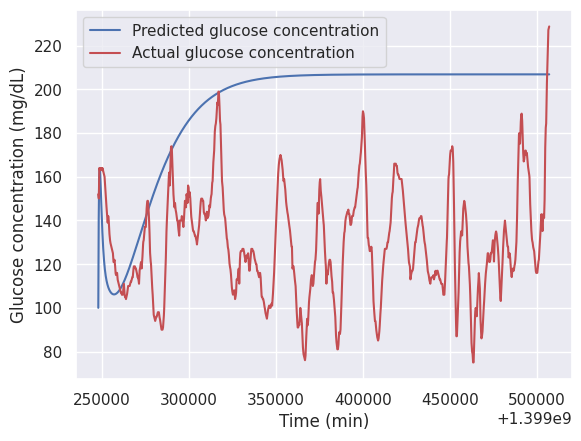

In [82]:
plt.plot(X_actual, G_predicted, label='Predicted glucose concentration')
plt.plot(X_actual, G_actual, 'r', label='Actual glucose concentration')
plt.xlabel('Time (min)')
plt.ylabel('Glucose concentration (mg/dL)')
plt.legend()
plt.show()